In [ ]:
import torch
from torch import nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path
from torch import nn

In [ ]:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


tensor([[ -0.4438, -10.5884],
        [  8.8043,   1.1452],
        [ -5.8449,   1.0225],
        [ -2.9761, -10.8911],
        [ -9.3188,   2.2779]]) tensor([3, 2, 4, 3, 0])


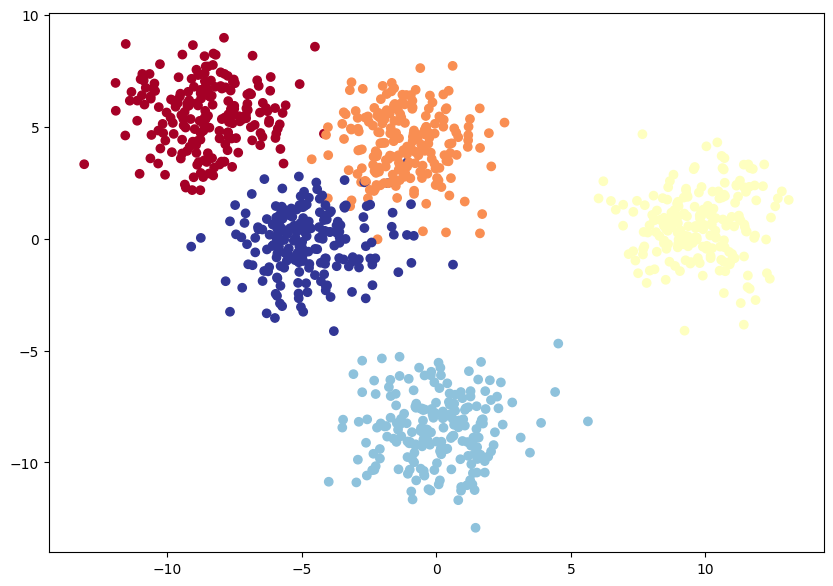

In [ ]:
NUM_CLASSES = 5
NUM_FEATURES = 2
RANDOM_SEED = 7

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

In [ ]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.8056,  0.4515,  0.5137,  0.1066,  0.5229],
        [-3.4724,  2.0098, -0.0411, -0.4709,  0.4025],
        [-2.7442,  0.7686,  0.5548,  0.1226,  0.7209],
        [ 4.5591, -1.1175, -0.1319, -0.3563, -1.0961],
        [-1.4850,  0.3003,  0.5267,  0.1272,  0.4756]],
       grad_fn=<SliceBackward0>)
tensor([[0.0265, 0.2531, 0.2693, 0.1793, 0.2718],
        [0.0029, 0.7058, 0.0908, 0.0591, 0.1415],
        [0.0090, 0.3017, 0.2436, 0.1581, 0.2876],
        [0.9771, 0.0033, 0.0090, 0.0072, 0.0034],
        [0.0377, 0.2245, 0.2815, 0.1888, 0.2675]], grad_fn=<SliceBackward0>)


In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(4)

epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.90549, Acc: 10.75% | Test Loss: 1.18969, Test Acc: 38.00%
Epoch: 100 | Loss: 0.15755, Acc: 95.00% | Test Loss: 0.11648, Test Acc: 93.50%
Epoch: 200 | Loss: 0.13197, Acc: 95.88% | Test Loss: 0.09269, Test Acc: 95.00%
Epoch: 300 | Loss: 0.10829, Acc: 96.88% | Test Loss: 0.07301, Test Acc: 99.00%
Epoch: 400 | Loss: 0.08688, Acc: 97.50% | Test Loss: 0.05631, Test Acc: 99.00%
Epoch: 500 | Loss: 0.07124, Acc: 97.88% | Test Loss: 0.04479, Test Acc: 99.50%
Epoch: 600 | Loss: 0.06136, Acc: 98.12% | Test Loss: 0.03788, Test Acc: 99.50%
Epoch: 700 | Loss: 0.05528, Acc: 98.25% | Test Loss: 0.03385, Test Acc: 99.50%
Epoch: 800 | Loss: 0.05141, Acc: 98.50% | Test Loss: 0.03144, Test Acc: 99.50%
Epoch: 900 | Loss: 0.04881, Acc: 98.62% | Test Loss: 0.02998, Test Acc: 99.50%


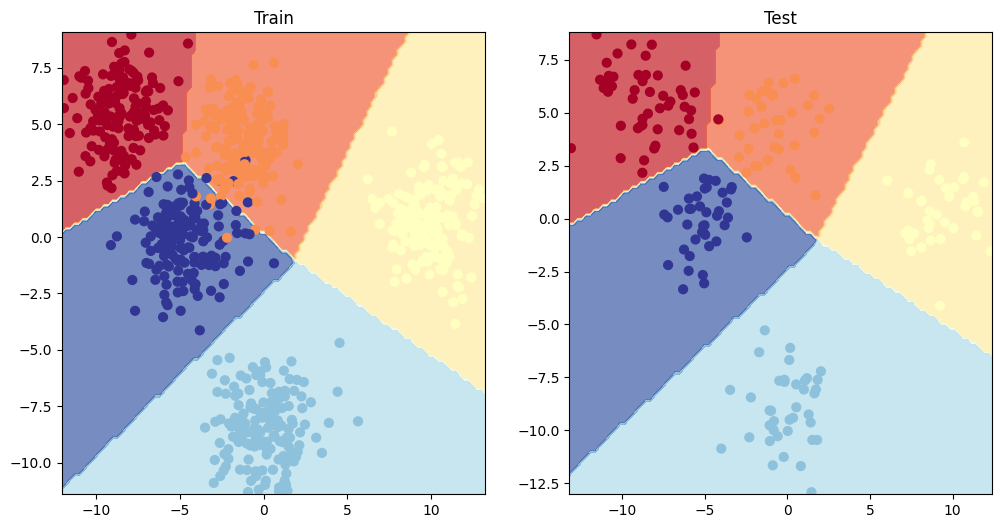

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)